**NOTICE:**

The predict value is not accurate unless the confirm value bigger than 1000‘s duration bigger than 15 days, so please not be scared and keep patient. Figures are for reference only.

**NOTE:**
* I copied the data collection part from this notebook : https://www.kaggle.com/alixmartin/covid-19-predictions
* Use the github data to predict newest case https://github.com/CSSEGISandData/COVID-19
* Can predict the province
* Full world predict (With China Data / Without China Data)
* More pretty code
* I will update the predict every day

**TODO:**
* Add deaths / recovered / active predict

**Please vote if you like!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
#check the old format
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
full_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed")

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
16429,NaN,Saint Kitts and Nevis,17.357822,-62.782998,2020-03-27,2
16430,Northwest Territories,Canada,64.825500,-124.845700,2020-03-27,1
16431,Yukon,Canada,64.282300,-135.000000,2020-03-27,3
16432,NaN,Kosovo,42.602636,20.902977,2020-03-27,86


### Cleaning Data

In [3]:
# cases 
#cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
#full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
# full_table[cases] = full_table[cases].fillna(0)

In [4]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed']]


def get_time_series_province(province):
    # for some countries, data is spread over several Provinces
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed']]

data looks a bit dirty, we might get an overly optimistic prediction because the last number is not the final one for instance.

The model is quite sensitive to this as it has only a handful of points to infer the dynamics from.


In [5]:
country = 'China'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed
Date,
2020-03-18,81102
2020-03-19,81156
2020-03-20,81250
2020-03-21,81305
2020-03-22,81435
2020-03-23,81498
2020-03-24,81591
2020-03-25,81661
2020-03-26,81782


In [6]:
#import time

#if country == 'New Zealand':
#    df.loc[datetime.datetime.strptime('2020-03-23', '%Y-%m-%d')] = 112
#    df.loc[datetime.datetime.strptime('2020-03-24', '%Y-%m-%d')] = 152
#    df.loc[datetime.datetime.strptime('2020-03-25', '%Y-%m-%d')] = 199
#    df.loc[datetime.datetime.strptime('2020-03-26', '%Y-%m-%d')] = 283
#    df.loc[datetime.datetime.strptime('2020-03-27', '%Y-%m-%d')] = 359
#
#df.tail(10)

I will use a model from a marketing paper by Emmanuelle Le Nagard and Alexandre Steyer, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected person / innovation adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

paper is available (in French) [here](https://www.jstor.org/stable/40588987)

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available, but adding a lag parameter could be attempted.

In [7]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [8]:

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 0]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

we need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [9]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt

array([8.22226866e+04, 1.40634133e-01, 7.42936206e+00])

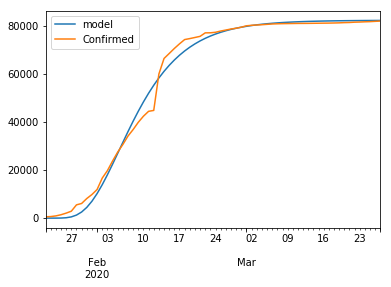

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['model']
pd.concat([model_sim, df], axis=1).plot()
plt.show()

let's extend the prediction curve

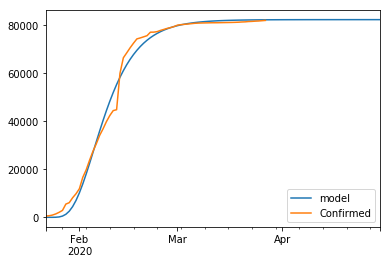

In [11]:
import datetime
start_date = df.index[0]
n_days = 100
extended_model_x = []
for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.concat([extended_model_sim, df], axis=1).plot()
plt.show()

let's display predictions for future weeks

In [12]:
df.tail()

,Confirmed
Date,
2020-03-23,81498
2020-03-24,81591
2020-03-25,81661
2020-03-26,81782
2020-03-27,81897


In [13]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0].astype({'model': 'int32'})

,Confirmed,model
2020-01-24,920,2
2020-01-27,"2,877",513
2020-01-30,"8,141",4452
2020-02-03,"19,716",17992
2020-02-06,"30,587",31461
2020-02-09,"39,829",44416
2020-02-12,"44,759",55223
2020-02-15,"68,413",63485
2020-02-18,"74,211",69467
2020-02-21,"75,550",73649


now let's compare the dynamic in different countries

In [14]:
def display_fit(df, opt, ax):
    model_x = []
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt, t)])
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['model']
    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

def display_extended_curve(df, opt, ax):
    start_date = df.index[0]
    n_days = 110
    extended_model_x = []
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['model']
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))


def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt) > 0:
        stats.append([country, *opt])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt, ax2)
        plt.show()

**Predict world (With China Data)**

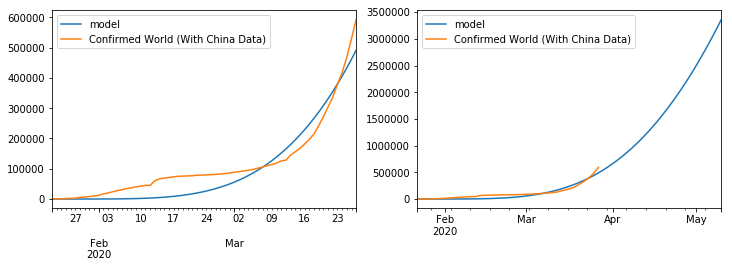

In [15]:
stats = []

df = full_table.drop(['Lat', 'Long'], axis=1).groupby('Date').sum()
df.columns = ['Confirmed World (With China Data)']
opt_display_model(df, stats)

**Predict world (Without China Data) **

Maybe event worse if except china data!

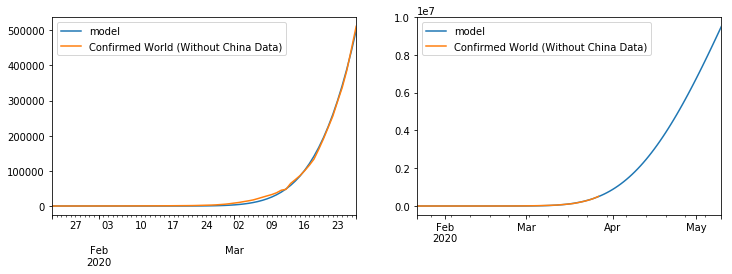

In [16]:
stats = []

df = full_table[full_table['Country/Region'] != 'China'].drop(['Lat', 'Long'], axis=1).groupby('Date').sum()
df.columns = ['Confirmed World (Without China Data)']
opt_display_model(df, stats)

**Predict by Province**

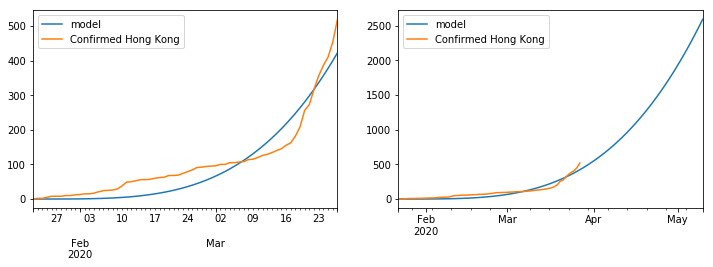

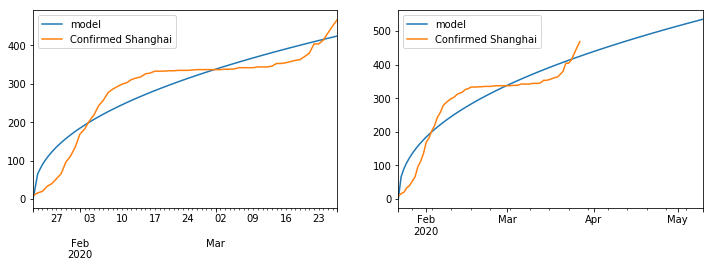

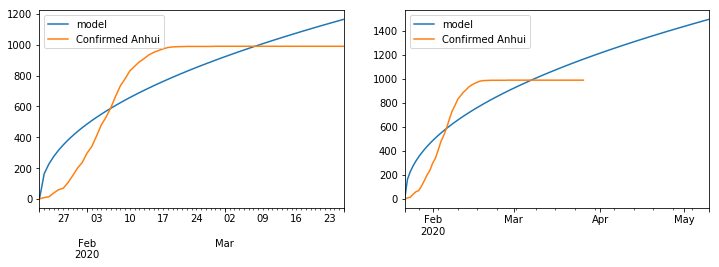

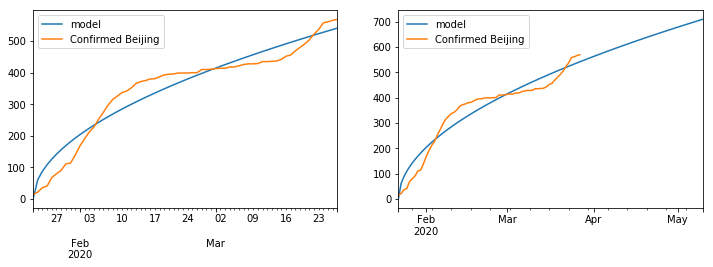

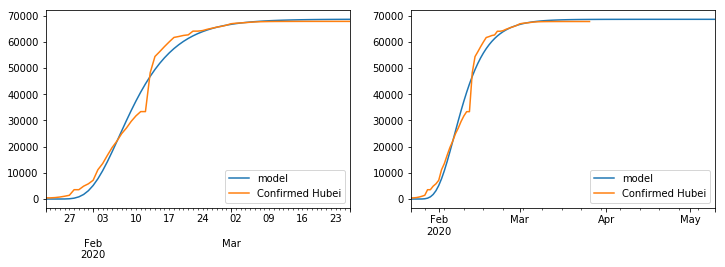

In [17]:
stats = []

# Province Specify
for Province in ['Hong Kong', 'Shanghai', 'Anhui', 'Beijing', 'Hubei']:
    df = get_time_series_province(Province)
    df.columns = [df.columns[0] + ' ' + Province]
    opt_display_model(df, stats)

**Predict by Specify Country**

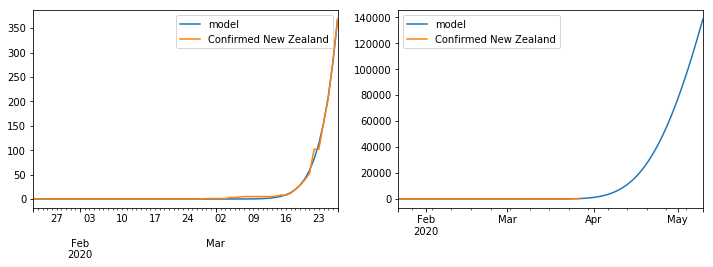

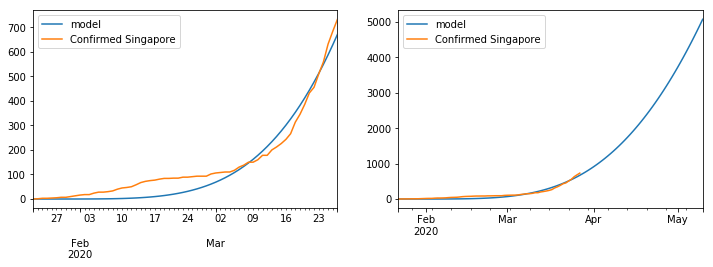

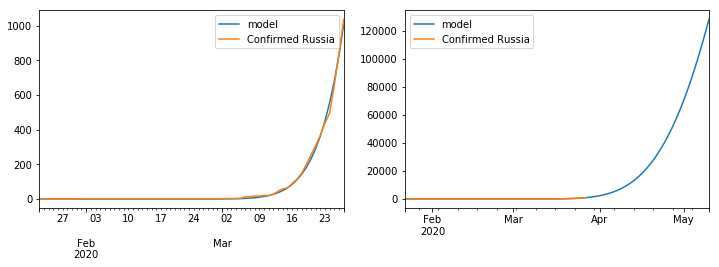

In [18]:
# Country Specify
stats = []
for country in ['New Zealand', 'Singapore', 'Russia']:
# for country in ['Sweden']:
    df = get_time_series(country)

    df.columns = [df.columns[0] + ' ' + country]
    
    opt_display_model(df, stats)

**Predict all country greater than 1000**

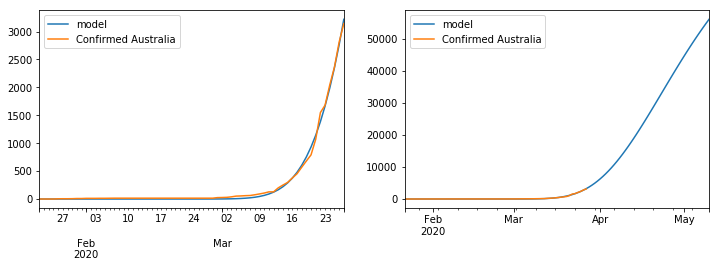

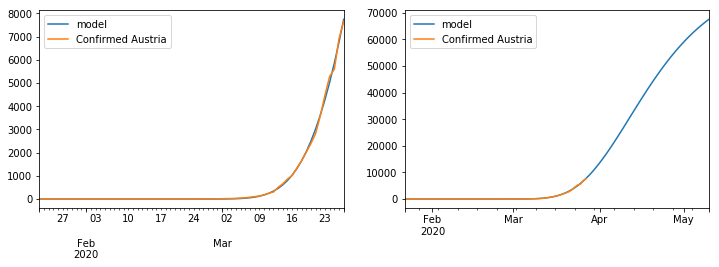

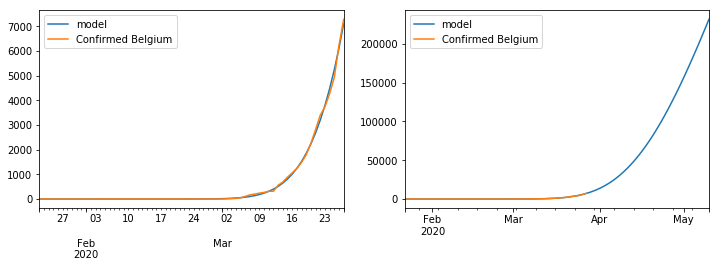

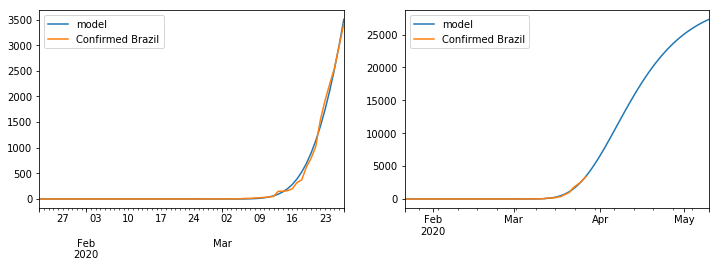

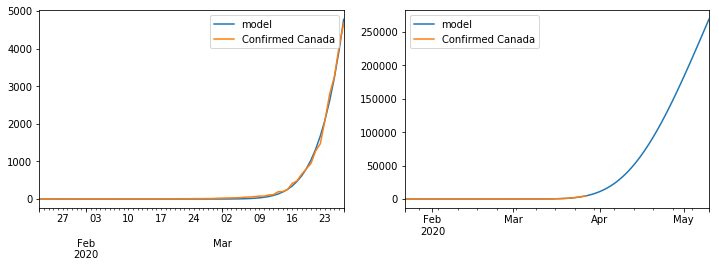

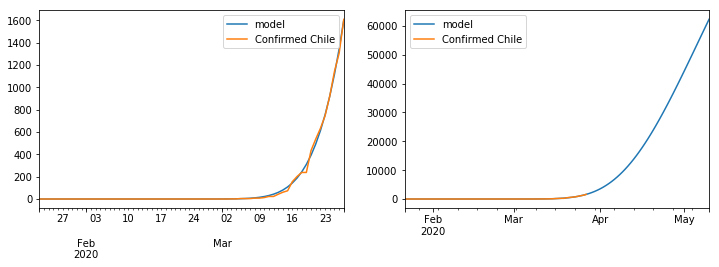

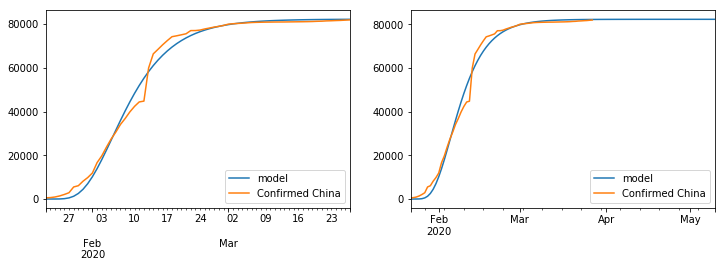

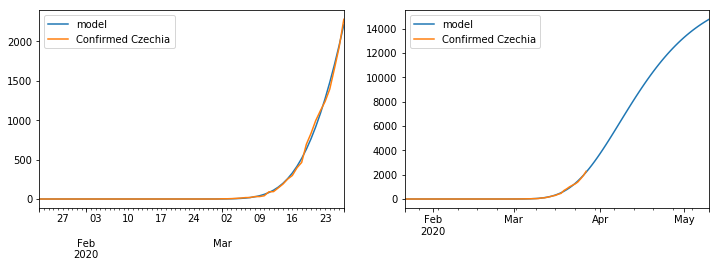

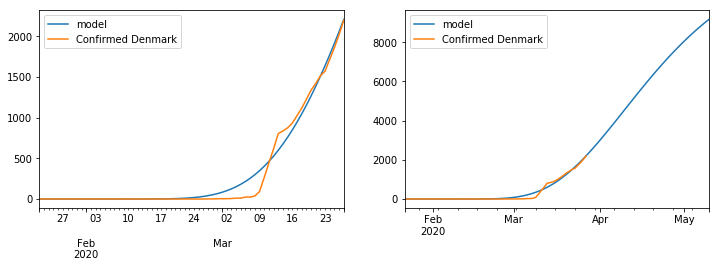

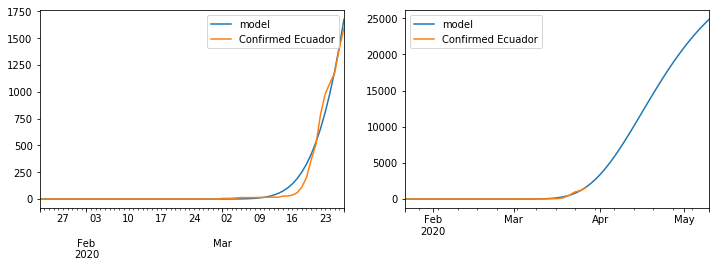

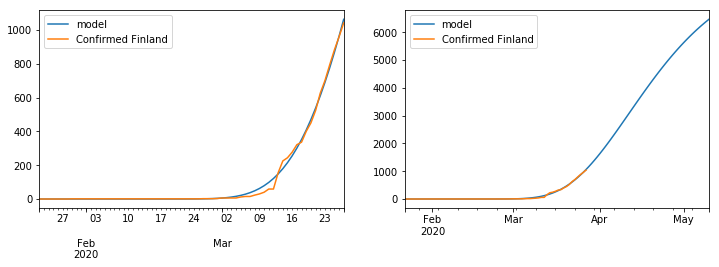

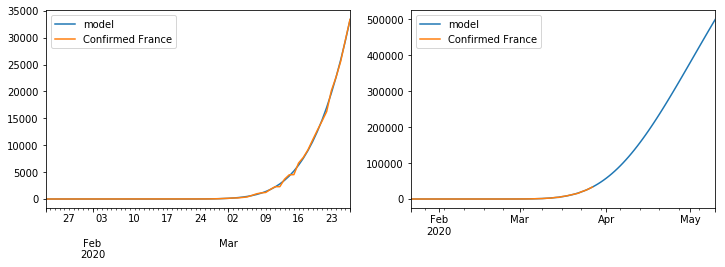

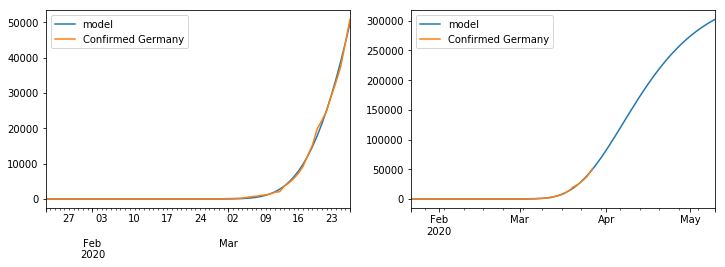

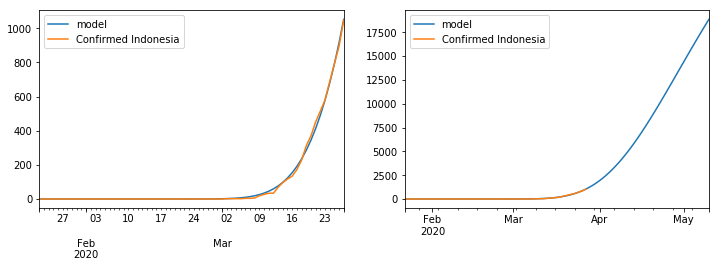

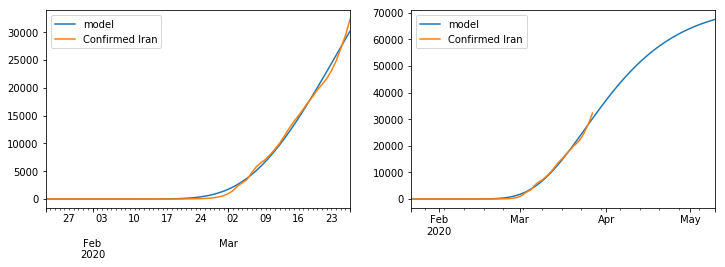

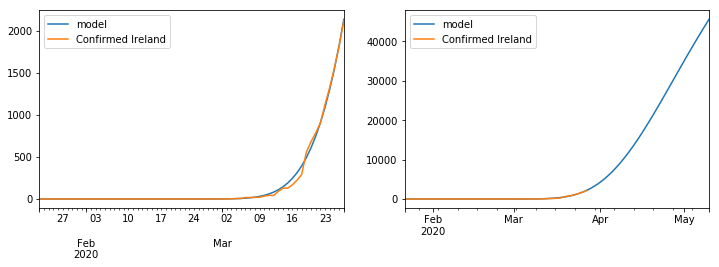

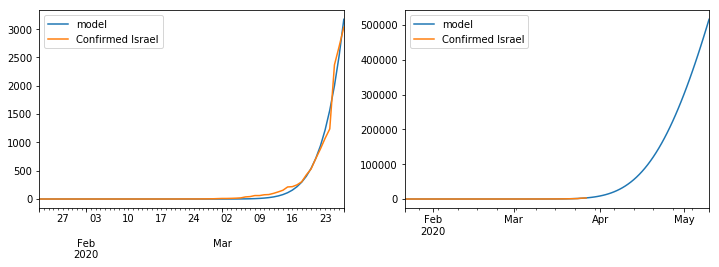

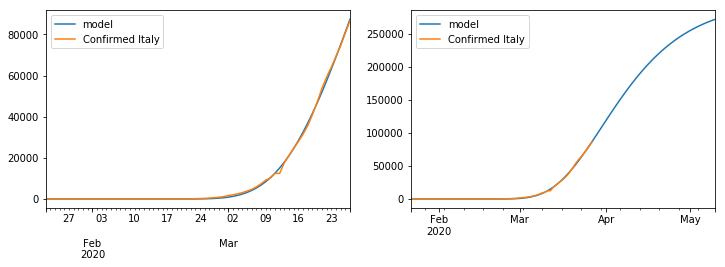

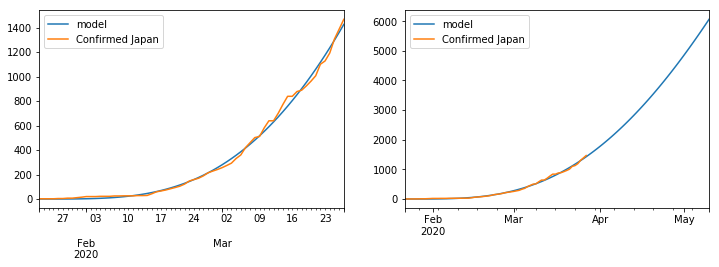

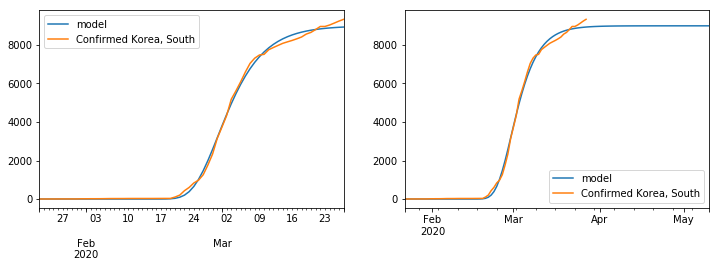

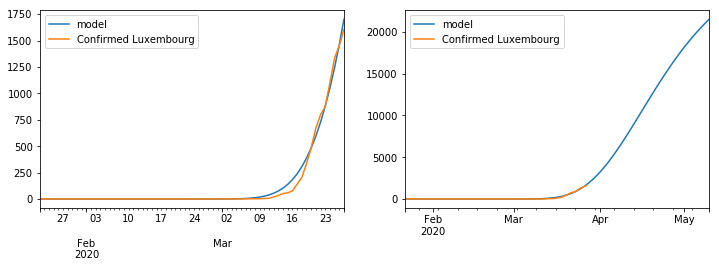

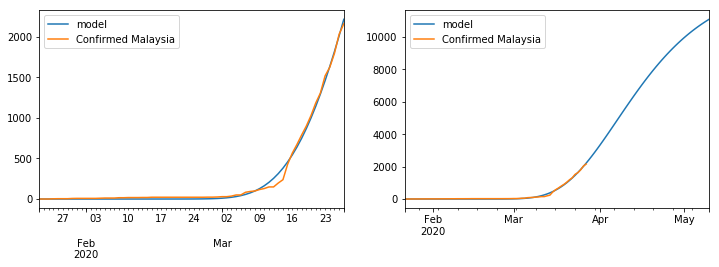

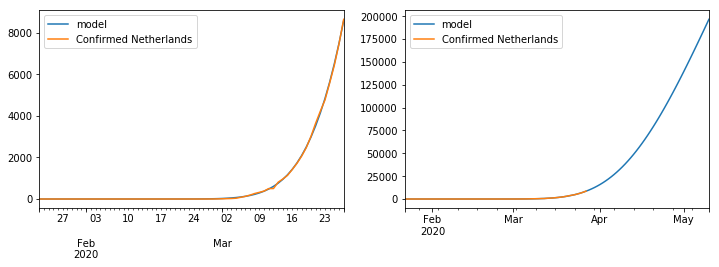

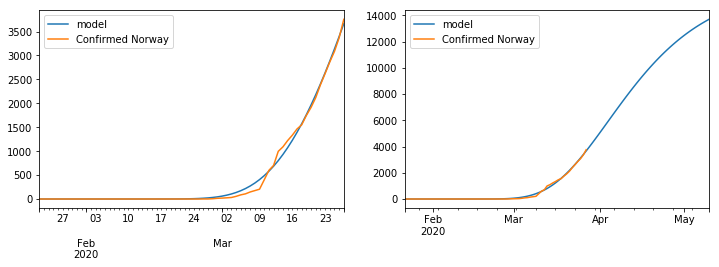

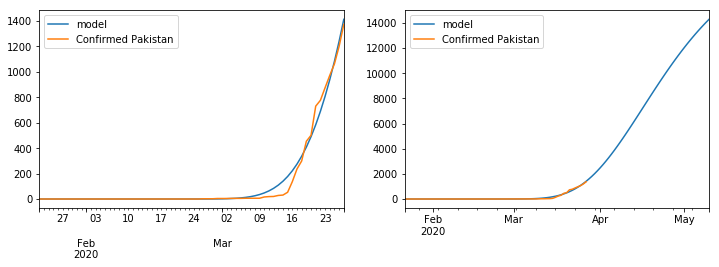

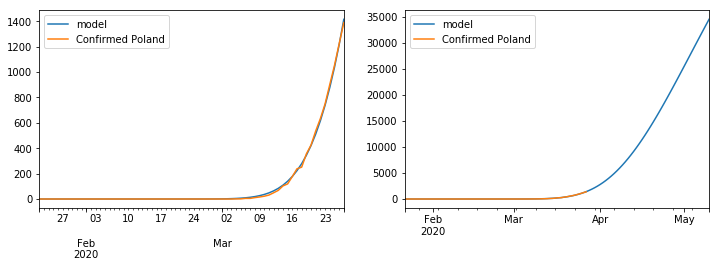

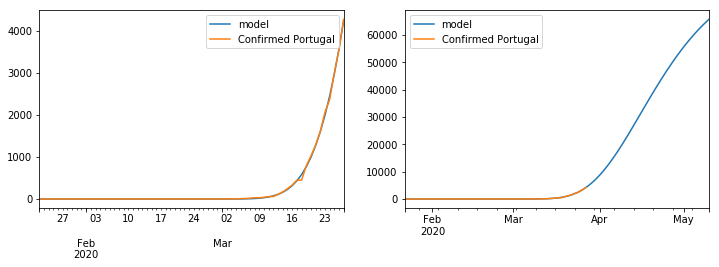

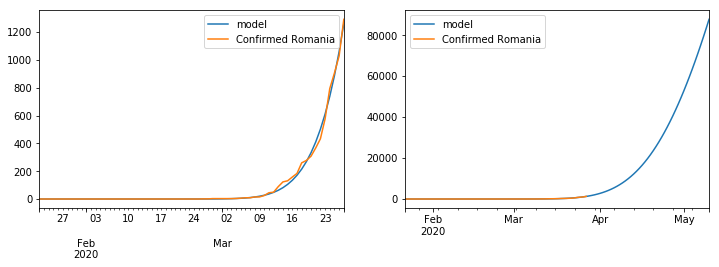

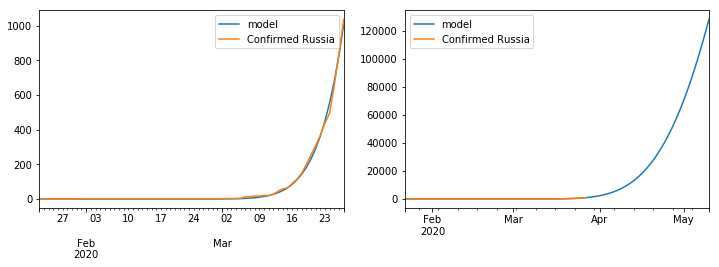

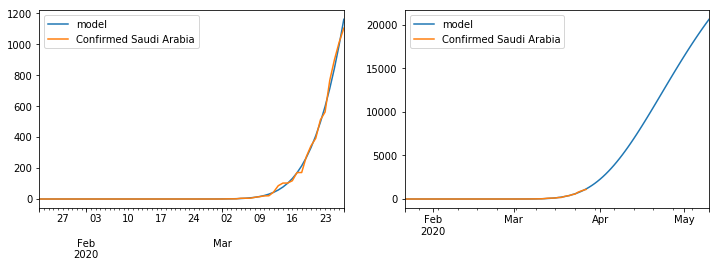

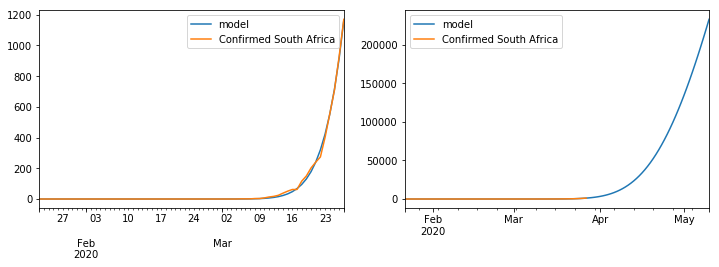

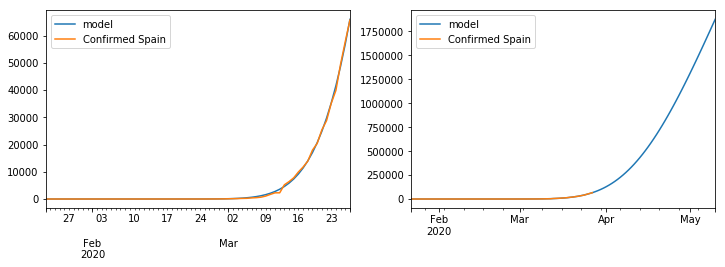

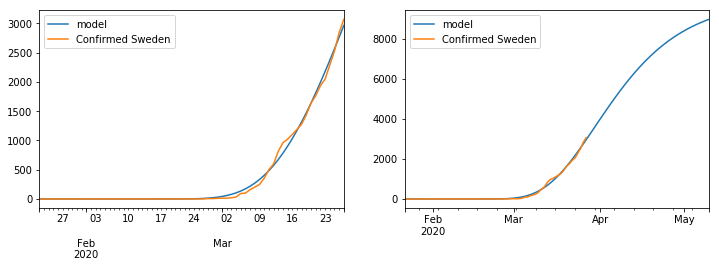

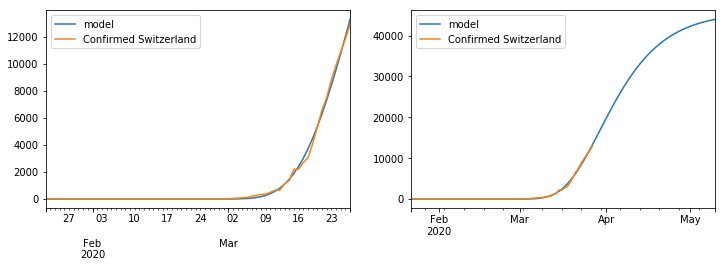

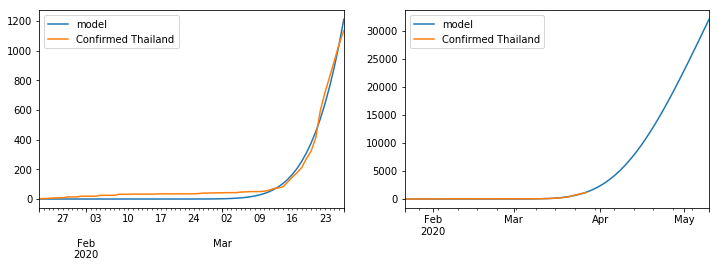

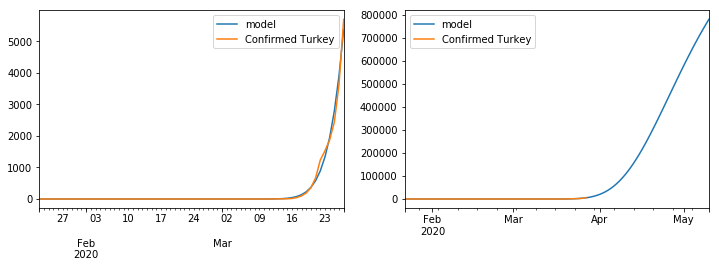

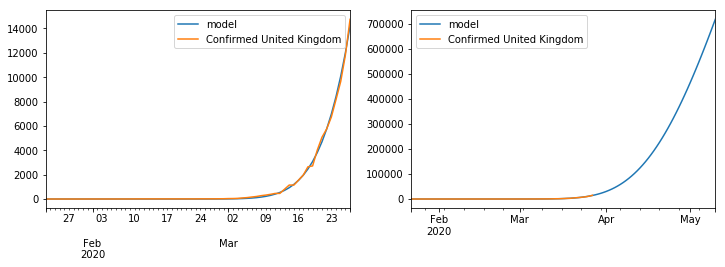

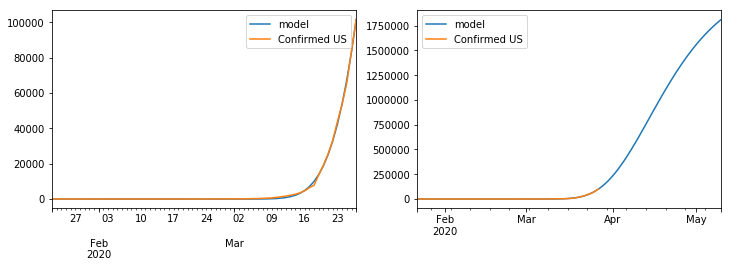

In [19]:
# All Country Confirmed Greater than 1000

stats = []
for country in full_table['Country/Region'].unique():
# for country in ['Sweden']:
    df = get_time_series(country)
    # only consider countries with at least 1000 cases (plus Sweden)
    if len(df) == 0 or (max(df['Confirmed']) < 1000): 
        continue
    df.columns = [df.columns[0] + ' ' + country]
    opt_display_model(df, stats)
stats_df = pd.DataFrame(stats)
# stats_df.columns = ['country', 'N', 'a', 'alpha', 'lag']
stats_df.columns = ['country', 'N', 'a', 'alpha']

we can see above that China and Korea are reaching a plateau, Iran is in the middle phase, while the other countries are in the exponential part of the curve

let's see if we can make some sense from the parameters

In [20]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'N': 'int'}).sort_values(by='N', ascending=False)

,country,N,a,alpha
31,Spain,5676818,0.0304,29.8197
36,United Kingdom,3066324,0.0283,31.1494
16,Israel,2733742,0.0306,45.8793
37,US,2223671,0.0616,167.4469
28,Russia,1581736,0.0225,27.9591
35,Turkey,1224839,0.0564,208.9570
30,South Africa,1201668,0.0316,50.6122
11,France,1097061,0.0328,27.6986
2,Belgium,878252,0.0278,26.7809
4,Canada,731721,0.0358,48.9306


N is the potential spread in the country if the dynamics since the beginning of the epidemy persist. One problem is that sometimes we're measuring the spread of testing rather than of the epidemy. For instance New York allegedly started tesing a lot of people, which might explain the current explosive dynamic in the US numbers.

Korea is an outlier, probably because two things happened there : an initial contagion to a large number of people in a short time through a religious sect, and then a fairly rapid containment of the epidemy.

The Iran data is also different from European countries, but there is some doubt about the accuracy of the data provided by the Iranian state.

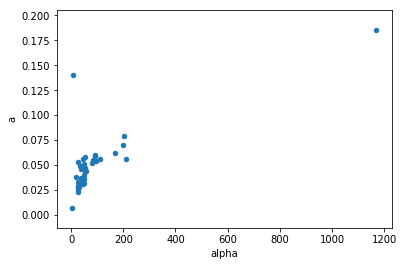

In [21]:
ax = stats_df.plot.scatter(x='alpha', y='a')
# ax.set_xlim([0, 100])
plt.show()